In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
PATH = "/content/drive/MyDrive/NLP/"
f = open(PATH + "new_paragraph_pairs_5296.json",)
data = json.load(f)

print(len(data))
f.close()

2


In [ ]:
import json
PATH = "/content/drive/MyDrive/Colab Notebooks/NLP/"
f = open(PATH + "paragraph_pairs_5296.json",)
data = json.load(f)

print(len(data))
f.close()

2


In [3]:
"""
Structure of data
Array
  - Expos
    - Document
      - List of Expos
  - Questions
    - Document
      - List of Questions
"""

'\nStructure of data\nArray\n  - Expos\n    - Document\n      - List of Expos\n  - Questions\n    - Document\n      - List of Questions\n'

In [4]:
# Start and end of labelling
START_INDEX = 0
NUM_LABELS = 10

unlabeled_questions = data[1][START_INDEX: START_INDEX + NUM_LABELS]
expos = data[0][START_INDEX:START_INDEX + NUM_LABELS]

In [5]:
# Insert the directory
import sys
import torch
sys.path.append( PATH + 'InferSent')

%pwd

'/content'

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
# Import InferSent models
from models import InferSent

V = 1
MODEL_PATH = PATH + 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH =  PATH +'GloVe/glove.840B.300d.txt'
infersent.set_w2v_path(W2V_PATH)

import json



messages = list()

for day in unlabeled_questions:
    for message in day:
        messages.append(message)

for day in expos:
    for message in day:
        messages.append(message)

infersent.build_vocab(messages, tokenize=True)

Found 3885(/3924) words with w2v vectors
Vocab size : 3885


In [8]:
# Return scores with threshold > 0.92

def return_high_scores(analyst_embedding, expo_embeddings, threshold=0.92):
    from scipy.spatial import distance

    qualifying = list()
    scores = list()

    for k, expo_embedding in enumerate(expo_embeddings):

        corr = 1 - distance.cosine(analyst_embedding, expo_embedding)

        if corr > threshold:
          qualifying.append(k)
          scores.append(corr)

    return qualifying, scores

In [9]:
from scipy.spatial import distance

from sklearn.decomposition import PCA
pca = PCA(n_components=300)

In [10]:
pairs = list()
# Check every document
for i in range(NUM_LABELS):

    try:
      analyst_embeddings = infersent.encode(unlabeled_questions[i], tokenize=True)

      # analyst_embeddings = pca.fit_transform(analyst_embeddings)

      expo_embeddings = infersent.encode(expos[i], tokenize=True)

      # expo_embeddings = pca.fit_transform(expo_embeddings)


      for j, analyst_embedding in enumerate(analyst_embeddings):
          qualifying,scores = return_high_scores(analyst_embedding, expo_embeddings)

          pairs.append((i,j, qualifying, scores))
    except:
      print(expos[i])
      print(unlabeled_questions[i])

/content/drive/MyDrive/NLP/InferSent/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]


In [11]:
print(pairs)

[(0, 0, [], []), (0, 1, [], []), (0, 2, [], []), (0, 3, [], []), (0, 4, [], []), (0, 5, [], []), (0, 6, [], []), (0, 7, [], []), (0, 8, [], []), (0, 9, [], []), (0, 10, [], []), (0, 11, [], []), (0, 12, [], []), (0, 13, [], []), (0, 14, [], []), (0, 15, [], []), (0, 16, [], []), (1, 0, [], []), (1, 1, [], []), (1, 2, [], []), (1, 3, [], []), (1, 4, [21], [0.9207601547241211]), (2, 0, [], []), (2, 1, [], []), (2, 2, [], []), (2, 3, [], []), (2, 4, [], []), (2, 5, [], []), (2, 6, [], []), (2, 7, [], []), (2, 8, [], []), (2, 9, [], []), (2, 10, [], []), (2, 11, [5, 6], [0.9239225387573242, 0.9249730706214905]), (3, 0, [], []), (3, 1, [], []), (3, 2, [], []), (3, 3, [], []), (3, 4, [], []), (3, 5, [], []), (3, 6, [], []), (3, 7, [], []), (3, 8, [], []), (4, 0, [], []), (4, 1, [], []), (4, 2, [], []), (4, 3, [], []), (4, 4, [], []), (4, 5, [], []), (4, 6, [], []), (5, 0, [], []), (5, 1, [], []), (5, 2, [], []), (5, 3, [], []), (5, 4, [], []), (5, 5, [], []), (5, 6, [], []), (5, 7, [], []), 

In [12]:
labeled_questions = []
labeled_expos = []

i = 0
pair_index, question_index, qualifying_expo_indices, scores = pairs[i]

question = unlabeled_questions[pair_index][question_index]

# Print the question first
print(question)

# Print possible choices and scores
for index, k in enumerate(qualifying_expo_indices):
  print(index, expos[pair_index][k], "Score: {}".format(scores[index])) 

Just on the bookings over the past -- I mean, this is like very short-term-focused, but are you hearing from any of your corporate accounts about adjusting bookings or whatever for the -- given United's performance over the last couple of weeks with various incidences?


In [13]:
output = []
for i in range(len(pairs)):
  pair_index, question_index, qualifying_expo_indices, scores = pairs[i]
  question = unlabeled_questions[pair_index][question_index]
  #output.append(question)
  #print(question)
  lis = [question]
  temp = []

  top_score = -100
  top_index = -1

  for index, k in enumerate(qualifying_expo_indices):
    #print(index, expos[pair_index][k], "Score: {}".format(scores[index]))
    if scores[index] > top_score:
      top_score = scores[index]
      top_index = k

  if top_index != -1:
    temp.append(expos[pair_index][top_index])
    lis.append(temp)
    output.append(lis)

In [14]:
from pprint import pprint 

In [15]:
print(len(output))

4


In [18]:
#PATH = "/content/drive/MyDrive/"
import json
f = open("/content/drive/MyDrive/NLP/new_multiple_choice_92sim.json", "w")

json.dump(output, f, indent = 6)

f.close() 

In [ ]:
pprint(output[100])

['Yes. Good morning and thank you. David, just a question for you. It really '
 "from the outside seems that UPS, under your leadership over – I don't know – "
 'the past year or maybe longer is taking more aggressive steps than you have '
 'in the past. I think we can look at that in terms of the pace of change at '
 'the management committee level, a higher CapEx budget, more aggressive '
 "investments, you've got the transformation initiatives. So from the outside, "
 "it does appear that you're taking a pretty aggressive approach.",
 ['In addition, I want to take a moment to recognize a true UPS partner, Myron '
  'Gray, for his many years of valued leadership. Myron has made a material '
  'impact on UPS during his 40 years, and we wish him the best in his '
  'retirement. As we look at the rest of the year, our key transformation '
  'initiatives are moving forward. The economic outlook remains positive, and '
  "we're sharply focused on executing our growth strategies. Consideri

In [ ]:
num_expo = []
count = 0
for i in output:
  if i[1] == []:
    count += 1
  else:
    num_expo.append(len(i[1]))
print(count)

13824


In [ ]:
print(num_expo)

[17, 3, 10, 4, 24, 26, 12, 9, 31, 40, 2, 30, 33, 36, 35, 26, 29, 19, 17, 8, 7, 4, 40, 32, 6, 27, 5, 5, 3, 19, 19, 20, 19, 21, 20, 18, 19, 19, 20, 6, 20, 19, 19, 29, 29, 18, 30, 32, 15, 19, 25, 34, 30, 24, 28, 32, 33, 22, 27, 16, 31, 32, 17, 37, 7, 19, 29, 9, 1, 28, 32, 39, 37, 20, 39, 22, 45, 31, 37, 24, 27, 40, 7, 8, 50, 12, 32, 5, 41, 34, 53, 4, 48, 34, 44, 37, 22, 36, 21, 10, 16, 20, 36, 15, 37, 18, 26, 20, 3, 28, 31, 12, 7, 29, 36, 39, 25, 7, 27, 14, 31, 29, 27, 24, 13, 32, 36, 22, 19, 16, 23, 43, 42, 28, 36, 23, 22, 34, 15, 20, 1, 40, 39, 38, 25, 29, 32, 36, 1, 25, 36, 33, 34, 2, 29, 33, 36, 38, 36, 34, 35, 36, 25, 20, 31, 23, 26, 25, 21, 23, 25, 25, 24, 22, 24, 9, 23, 23, 22, 21, 36, 3, 31, 35, 8, 35, 15, 31, 37, 32, 15, 16, 17, 18, 34, 36, 36, 22, 24, 20, 2, 20, 20, 4, 20, 20, 1, 12, 19, 8, 20, 20, 19, 20, 16, 20, 31, 23, 1, 22, 20, 30, 22, 31, 26, 22, 12, 27, 28, 23, 29, 18, 24, 29, 22, 33, 35, 34, 37, 34, 35, 27, 1, 29, 35, 35, 14, 29, 11, 2, 16, 3, 6, 13, 7, 2, 39, 22, 31, 17

In [ ]:
import statistics as st

In [ ]:
print(st.mean(num_expo))
print(len(num_expo))

15.393684210526315
17575


(array([1454., 1010.,  780.,  772.,  679.,  715.,  589.,  630.,  608.,
         609.,  565.,  567.,  493.,  508.,  468.,  487.,  437.,  418.,
         384.,  365.,  367.,  330.,  303.,  263.,  290.,  239.,  246.,
         234.,  257.,  179.,  229.,  190.,  168.,  157.,  133.,  149.,
         120.,  112.,   98.,   88.,   72.,   81.,   70.,   61.,   52.,
          49.,   43.,   51.,   37.,   40.,   39.,   28.,   25.,   28.,
          32.,   23.,   13.,   11.,   17.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
        40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
        53., 54., 55., 56., 57., 58., 59., 60.]),
 <a list of 59 Patch objects>)

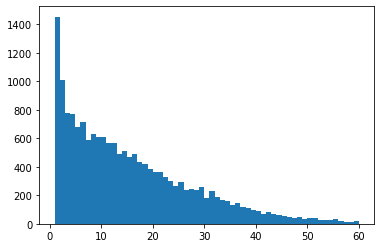

In [ ]:
import matplotlib
matplotlib.pyplot.hist(num_expo, bins=59, range=(1,60))

In [ ]:
#PATH = "/content/drive/MyDrive/"
import json
f = open("/content/drive/MyDrive/NLP/multiple_choice_90.json", "w")

json.dump(output, f, indent = 6)

f.close() 

In [ ]:
gloveFile = W2V_PATH
import numpy as np
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    with open(gloveFile, encoding="utf8" ) as f:
        content = f.readlines()
    model = {}
    for line in content:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model

import re
from nltk.corpus import stopwords
import pandas as pd

def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    cleaned_words = list(set([w for w in words if w not in stopword_set]))

    return cleaned_words

def cosine_distance_between_two_words(word1, word2):
    import scipy
    return (1- scipy.spatial.distance.cosine(model[word1], model[word2]))

def calculate_heat_matrix_for_two_sentences(s1,s2):
    s1 = preprocess(s1)
    s2 = preprocess(s2)
    result_list = [[cosine_distance_between_two_words(word1, word2) for word2 in s2] for word1 in s1]
    result_df = pd.DataFrame(result_list)
    result_df.columns = s2
    result_df.index = s1
    return result_df

def cosine_distance_wordembedding_method(s1, s2):
    import scipy
    vector_1 = np.mean([model[word] for word in preprocess(s1)],axis=0)
    vector_2 = np.mean([model[word] for word in preprocess(s2)],axis=0)
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    print('Word Embedding method with a cosine distance asses that our two sentences are similar to',round((1-cosine)*100,2),'%')
    return round((1-cosine)*100,2)

def heat_map_matrix_between_two_sentences(s1,s2):
    df = calculate_heat_matrix_for_two_sentences(s1,s2)
    import seaborn as sns
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(5,5)) 
    ax_blue = sns.heatmap(df, cmap="YlGnBu")
    # ax_red = sns.heatmap(df)
    print(cosine_distance_wordembedding_method(s1, s2))
    return ax_blue

def cosine(s1,s2):
  import scipy
  v1 = []
  for word in preprocess(s1):
    try:
      embedding = model[word]
      v1.append(embedding)
    except:
      #print("shit!!!")
      pass
  #vector_1 = np.mean(v1,axis=0)
  v2 = []
  for word in preprocess(s2):
    try:
      embedding = model[word]
      v2.append(embedding)
    except:
      #print("shit!!!")
      pass
  #vector_2 = np.mean(v2,axis=0)
  
  max_sim_lis = [0]
  for i in v2:
    max_sim = 0
    for j in v1:
      cosine = scipy.spatial.distance.cosine(i, j)
      sim = round((1-cosine)*100,2)
      if sim > max_sim:
        max_sim = sim
    max_sim_lis.append(max_sim)
  return st.mean(max_sim_lis)
  #cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
  #return round((1-cosine)*100,2)

In [ ]:
similarity = []
for i in range(0,1000):
  
  dic = {}
  for exp in range(len(expo[i])):
    for an in range(len(ana[i])):
      cos = cosine(expo[i][exp], ana[i][an])
      dic[(exp,an)] = cos
  similarity.append(dic)
print(similarity[0])

In [ ]:
sorted_dic = sorted(similarity[target].items(), key = 
             lambda kv:(kv[1], kv[0]))
top_pairs = sorted_dic[-10:]
print(top_pairs)